# Community Detection Methods Using NetworkX


## Description
Real-world networks reveal clustering behaviour, which is exhibited in the formation of communities/clusters/partitions (terms are used interchangeably in this notebook) in the graph structure. When studying networks, their structure and function, it is crucial to identify these bunchings. In this recipe, we explore these different structures (including **cliques** and **connected components**) with a strong focus on clustering and community detection. In particular, we explore two general methods, and three submethods:

1. Divisive Method
    - Girvan-Newman algorithm using _edge betweenness_
2. Agglomerative Method
    - Ravasz (hierarchical clustering) algorithm using _distance matrix_
    - Louvain method using _modularity_ 



In [1]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import operator

## For Hierarchical Clustering
from scipy.cluster import hierarchy
from scipy.spatial import distance

## Network analysis
import networkx as nx

## For Community Detection (Louvain Method)
## https://github.com/taynaud/python-louvain
import community



## 1. Load the Network

Here, we use the Zachary's karate club network $G$ to illustrate some concepts on network structures. 

In [2]:
G = nx.karate_club_graph()

## 2. Network Structure and Properties

1. Clique
2. Connected Components
3. Edge Betweenness 

In [3]:
print("Number of nodes: ", G.size())
print("Number of edges: ", G.order())

Number of nodes:  78
Number of edges:  34


In [4]:
pos = nx.fruchterman_reingold_layout(G)

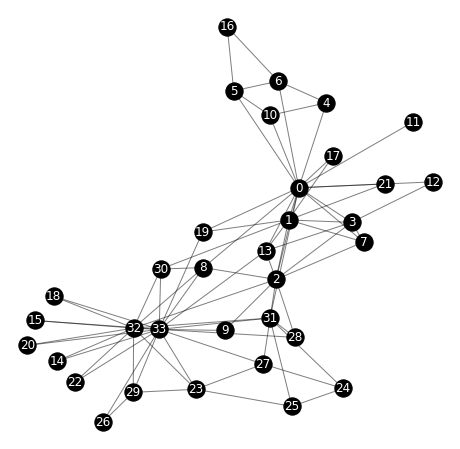

In [5]:
plt.figure(figsize=(8,8));
plt.axis("off");
nx.draw_networkx_nodes(G, pos, node_size=300, node_color="black");
nx.draw_networkx_edges(G, pos, alpha=0.500);
nx.draw_networkx_labels(G, pos, font_color="white");
plt.show();

### Real-world partition

In [6]:
mrhi = [0,1,2,3,4,5,6,7,8,10,11,12,13,16,17,19,21]
johna = [9,14,15,18,20,22,23,24,25,26,27,28,29,30,31,32,33]

for mem in G.nodes():
    if mem in mrhi:
        G.nodes[mem]["group"] = "mrhi"
    else:
        G.nodes[mem]["group"] = "johna"

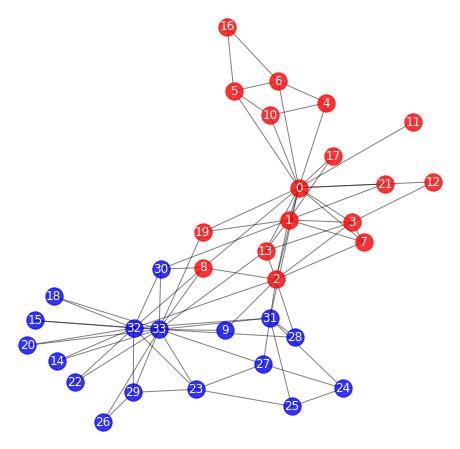

In [7]:
plt.figure(figsize=(8,8));
plt.axis("off");
nx.draw_networkx_nodes(G,pos,
                       nodelist=mrhi,
                       node_color='r',
                       node_size=300,
                   alpha=0.8);
nx.draw_networkx_nodes(G,pos,
                       nodelist=johna,
                       node_color='b',
                       node_size=300,
                   alpha=0.8);
nx.draw_networkx_edges(G, pos, alpha=0.5);
nx.draw_networkx_labels(G, pos, font_color="white");

### Cliques
Cliques are **complete subgraphs**; that is, subgraphs where the nodes are all _directly_ connected to each other. For example, using the Karate Club network $K$, the cliques are listed below. Note that any two connected nodes in an undirected network are considered to form a **clique**.

In [8]:
list(nx.find_cliques(G))

[[0, 1, 17],
 [0, 1, 2, 3, 13],
 [0, 1, 2, 3, 7],
 [0, 1, 19],
 [0, 1, 21],
 [0, 4, 10],
 [0, 4, 6],
 [0, 5, 10],
 [0, 5, 6],
 [0, 8, 2],
 [0, 11],
 [0, 12, 3],
 [0, 31],
 [1, 30],
 [2, 32, 8],
 [2, 9],
 [2, 27],
 [2, 28],
 [5, 16, 6],
 [33, 32, 8, 30],
 [33, 32, 14],
 [33, 32, 15],
 [33, 32, 18],
 [33, 32, 20],
 [33, 32, 22],
 [33, 32, 23, 29],
 [33, 32, 31],
 [33, 9],
 [33, 13],
 [33, 19],
 [33, 26, 29],
 [33, 27, 23],
 [33, 28, 31],
 [24, 25, 31],
 [24, 27],
 [25, 23]]

## 3. Divisive Method: The Girvan-Newman Algorithm
### Edge Betweenness
The **betweenness** of an edge $e$ is the fraction of shortest-paths that course through it. 

$$c_B(e)=\sum _{i,j \in V}\frac{\sigma (i,j)|e}{\sigma (i,j)},$$

where $\sigma(i,j)$ is the total number of shortest paths and $\sigma (i,j)|e$ is the number of shortest paths that pass through edge $e$. In `networkx`, the function is `edge_betweenness_centrality(G)`. Below, we illustrate the function using Zachary's karate club $K$.


In [9]:
#order the dictionary by value, which is the edge betweeness of two nodes
ebet = nx.edge_betweenness_centrality(G)
sorted_ebet = sorted(ebet.items(), key=operator.itemgetter(1), reverse=True)
sorted_ebet[0:5]

[((0, 31), 0.1272599949070537),
 ((0, 6), 0.07813428401663695),
 ((0, 5), 0.07813428401663694),
 ((0, 2), 0.0777876807288572),
 ((0, 8), 0.07423959482783014)]

Iteratively remove edges with the highest edge betweenness. For purpose of illustration, we first make a copy of the karate club network $K$. We then perform $i=10$ iterations of edge removal.

In [10]:
def remove_top_ebet(G):
    ebet = nx.edge_betweenness_centrality(G)
    sorted_ebet = sorted(ebet.items(), key=operator.itemgetter(1), reverse=True)
    edge_to_remove = sorted_ebet[0]
    G.remove_edge(*edge_to_remove[0])

    return G



In [11]:
G2 = G.copy()
for i in range(10):
    G2=remove_top_ebet(G2)

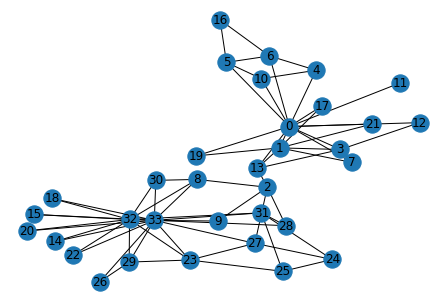

In [12]:
nx.draw(G2, pos)
nx.draw_networkx_labels(G2, pos)
plt.show()

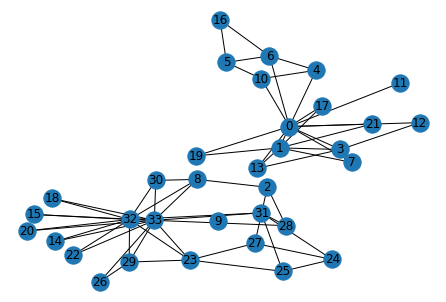

In [13]:
for i in range(5):
    G2=remove_top_ebet(G2)
    
nx.draw(G2, pos)
nx.draw_networkx_labels(G2, pos)
plt.show()

The algorithm for finding "communities" based on edge betweenness removal was presented by Girvan-Newmann in their [2002 PNAS paper](http://www.pnas.org/content/99/12/7821). Based on the method implemented, the algorithm is classified as a _dividive procedure_.

In [14]:
def girvan_newman (G):

    if len(G.nodes()) == 1:
        return [G.nodes()]

    def find_best_edge(G0):
        """
        Networkx implementation of edge_betweenness
        returns a dictionary. Make this into a list,
        sort it and return the edge with highest betweenness.
        """
        eb = nx.edge_betweenness_centrality(G0)
        eb_il = eb.items()
        eb_il.sort(key=lambda x: x[1], reverse=True)
        return eb_il[0][0]

    components = nx.connected_component_subgraphs(G)

    while len(components) == 1:
        G.remove_edge(*find_best_edge(G))
        components = nx.connected_component_subgraphs(G)

    result = [c.nodes() for c in components]

    for c in components:
        result.extend(girvan_newman(c))

    return result

### Connected Components

**Connected components** are subgraphs where all the nodes are connected to each via a path. Unlike **cliques**, they don't have to be _directly_ connected. Moreover, the **Giant Component** refers to the network's largest component.

In [15]:
print(f"Number of components: {len(list(nx.connected_components(G2)))}")
list(nx.connected_components(G2))

Number of components: 3


[{0, 1, 3, 4, 5, 6, 7, 10, 11, 12, 13, 16, 17, 19, 21},
 {2, 8, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33},
 {9}]

## 4. Agglomerative Method: Hierarchical Clustering
In this method, we start with a **distance matrix** $D$, which is a matrix that provides the distance between two nodes $i$ and $j$ in network $G$. Using $D$, we then perform [hierarchical clustering](http://docs.scipy.org/doc/scipy-0.17.0/reference/cluster.hierarchy.html#module-scipy.cluster.hierarchy) in a recursive manner, group _similar_ nodes at each step. There are various ways to perform the similarity grouping using _agglomerative procedures_ such as **single**, **complete**, and **average**, to name a few. In the example below, we implement the [average/UPGMA linkage](http://docs.scipy.org/doc/scipy-0.17.0/reference/generated/scipy.cluster.hierarchy.average.html#scipy.cluster.hierarchy.average), which is the one implemented in the Ravasz Algorithm published in [Science in 2002](http://science.sciencemag.org/content/297/5586/1551). 

In the following cells, we perform hierarchical clustering and visualize the order in which the nodes are grouped together in communities.


In [16]:
'''
The original code was written by Drew Conway and Aric Hagberg and was later 
modified by Maksim Tsvetovat for his book titled “Social Network Analysis for Startups”.
A different agglomerative procedure is implemented.
'''

def create_hc(G, t):
    ## Set-up the distance matrix D
    labels=G.nodes()    # keep node labels
    path_length=dict(nx.all_pairs_shortest_path_length(G))
    distances=np.zeros((len(G),len(G)))
    for u,p in path_length.items():
        for v,d in p.items():
            distances[u][v]=d

    # Create hierarchical cluster (HC)
    # There are various other routines for agglomerative clustering, 
    # but here we create the HCs using the complete/max/farthest point linkage 
    Y = distance.squareform(distances) ## the upper triangular of the distance matrix 
    Z = hierarchy.average(Y)
    
    # This partition selection (t) is arbitrary, for illustrive purposes
    membership=list(hierarchy.fcluster(Z,t=t))
    
    # Create collection of lists for blockmodel
    partition = defaultdict(list)
    for n,p in zip(list(range(len(G))),membership):
        partition[p].append(labels[n])
        
    return Z, membership, partition

In [17]:
Z, membership, partition = create_hc(G, t=1.15) 

In [18]:
partition = {}
i = 0
for i in range(len(membership)):
    partition[i]=membership[i]

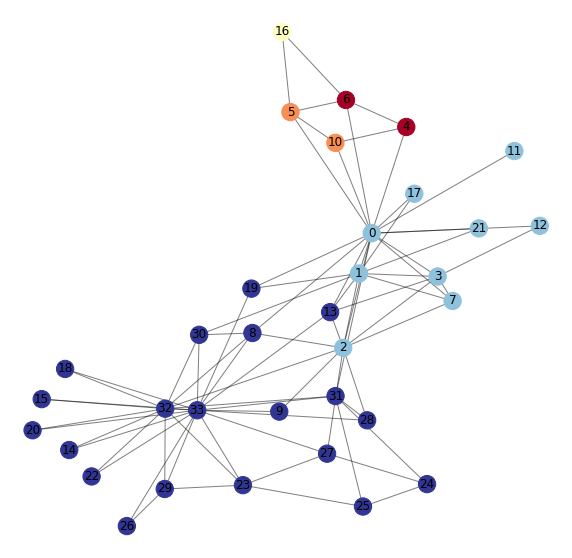

In [19]:
plt.figure(figsize=(10,10))
plt.axis('off')

nx.draw_networkx_nodes(G, pos, cmap=plt.cm.RdYlBu, node_color=list(partition.values()))
nx.draw_networkx_edges(G, pos, alpha=0.5)
nx.draw_networkx_labels(G, pos)
plt.show()

### Dendrogram
The dendrogram allows us to visualize the order in which nodes are grouped together in the clustering process.

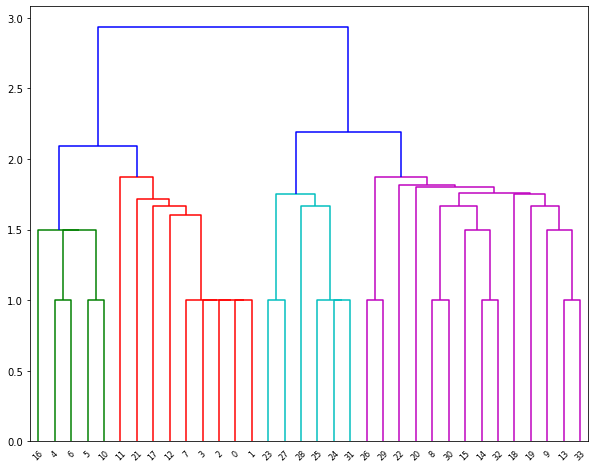

In [20]:
plt.figure(figsize=(10,8))
hierarchy.dendrogram(Z)
plt.show()

## 5. Modularity-Based Community Detection: The Louvain Method

The **community detection algorithm** that we implement in this notebook is a **modularity**-based algorithm. The **modularity** $M_c$ quantifies how good a "community" or partition is, and is given by

\begin{equation}
M_c = \sum _{c=1} ^{n_c} \left[ \frac{L_c}{L} - \left (\frac{k_c}{2L} \right)^2\right]
\end{equation}

where $n_c$ is the number of communiies, $L_c$ is the number of links within the community, $k_c$ is the total degree of nodes belonging to the community, and $L$ is the total number of links in the network. The illustration below that is taken from the slide deck shows how modularity is calculated.

<img src="./images/Modularity_Calc.png" width="75%">

The higher the network modularity is, the more optimal the partitionioning. And, if you only have a single community, $M=0$.

<img src="./images/Modularity.png" width="75%">

In this recipe, we implement a modularity-maximization algorithm called the Louvain algorithm. We go back to Zachary's karate club and find the best partitions.

In [21]:
partition = community.best_partition(G)

Now, let's redraw the network; this time, highlighting the different communities by node color.

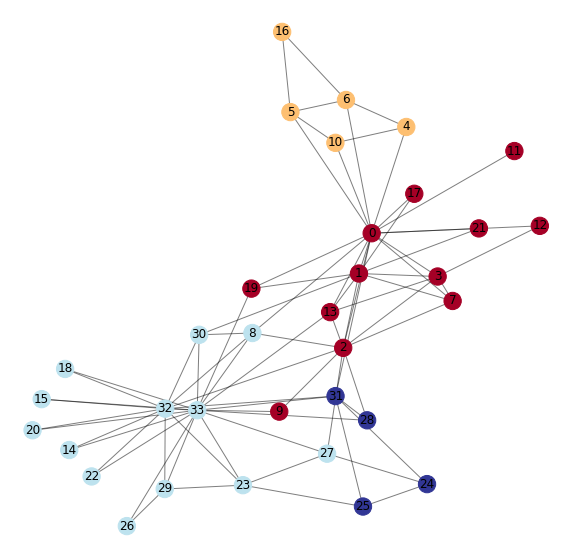

In [22]:
plt.figure(figsize=(10,10))
plt.axis('off')

nx.draw_networkx_nodes(G, pos, cmap=plt.cm.RdYlBu, node_color=list(partition.values()))
nx.draw_networkx_edges(G, pos, alpha=0.5)
nx.draw_networkx_labels(G, pos)
plt.show()

The algorithm produces four (4) partitions. Let's compare this partition to the actual.

{0: Text(0.1639653844524112, 0.3185353064630194, '0'),
 1: Text(0.1380786774562276, 0.1821963959960416, '1'),
 2: Text(0.10594952931730602, -0.06940942805737504, '2'),
 3: Text(0.2983677351526611, 0.17205920056493235, '3'),
 4: Text(0.2344935014415011, 0.6781823510575425, '4'),
 5: Text(-0.001604565527065651, 0.7286239357604409, '5'),
 6: Text(0.11158137538042455, 0.7695841991322699, '6'),
 7: Text(0.3289080337471868, 0.0893069286368806, '7'),
 8: Text(-0.07904566718871162, -0.019158917576212776, '8'),
 9: Text(-0.024355511369137824, -0.28520768214210906, '9'),
 10: Text(0.09000748151558745, 0.6245412635682683, '10'),
 11: Text(0.4547770341347294, 0.5967266780466591, '11'),
 12: Text(0.5066118676529276, 0.34354844797088124, '12'),
 13: Text(0.079338673774413, 0.05151222707571446, '13'),
 14: Text(-0.4522751135899916, -0.41521309969577225, '14'),
 15: Text(-0.5083772252970796, -0.24294611725039186, '15'),
 16: Text(-0.018460159969570615, 1.0, '16'),
 17: Text(0.25081761395423446, 0.4521

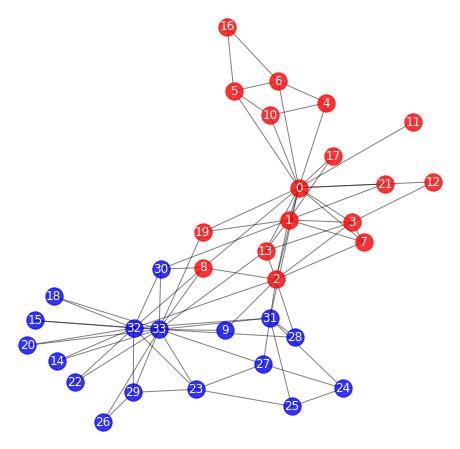

In [23]:
plt.figure(figsize=(8,8))
plt.axis("off")
nx.draw_networkx_nodes(G,pos, nodelist=mrhi, node_color='r', node_size=300, alpha=0.8)
nx.draw_networkx_nodes(G,pos, nodelist=johna, node_color='b', node_size=300, alpha=0.8)
nx.draw_networkx_edges(G, pos, alpha=0.5)
nx.draw_networkx_labels(G, pos, font_color="white")

## Some Real-World Networks
### Example 1: The Marvel Universe
There are two types of Marvel Universe networks that is [available on the web](http://exposedata.com/marvel/), the Comic Network and the Hero Network. The Comic Network connects the characters to the commic issues they appeared in; on ther hand, the Hero Network represents the connections between characters as they appear in the same comic issue (weighted). In this notebook, we look at the Hero Network.

In [25]:
# import unicodecsv as csv
import csv
M = nx.Graph(name="Marvel Universe")
reader = csv.reader(open("./data/hero-network.csv", 'rU'))
for row in reader:
    M.add_edge(*row)

/home/bioinformatica/.local/share/virtualenvs/Ironhack-OdDBNwqQ/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: 'U' mode is deprecated
  after removing the cwd from sys.path.


To export this network for use in **Gephi**, use

```python
nx.write_gexf(M, "marvel_universe.gexf")
```

#### Graph Statistics

In [26]:
M.size() #number of edges

167219

In [27]:
M.order() #number of nodes

6426

In [28]:
M_cliques=list(nx.find_cliques(M))

In [42]:
M_cliques[0]

['KRUELLA',
 'DOMINO III/BEATRICE/',
 'THUNDERBIRD II/JAMES',
 'MIRAGE II/DANIELLE M',
 'BOOMER/TABITHA SMITH',
 'CANNONBALL II/SAM GU',
 'LEONARD, DR.',
 'BEDLAM/JESSE AARONSO',
 'SKIDS/SALLY BLEVINS',
 'SIRYN/THERESA ROURKE',
 'LOCUS',
 'CISCERNOS, SELENA',
 'KALE, JENNIFER',
 'SUNSPOT/ROBERTO DACO',
 'BENCHLEY',
 'PANDEMONIA']

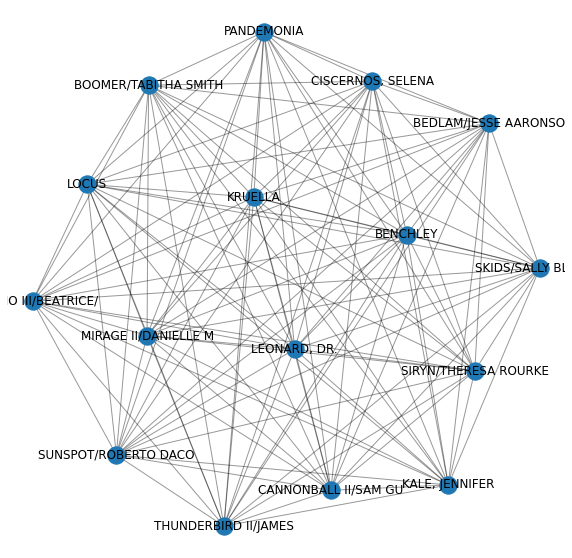

In [54]:
M1 = M.subgraph(M_cliques[0]) 
pos = nx.spring_layout(M1)
  
plt.figure(figsize=(10,10))
plt.axis('off')
nx.draw_networkx_nodes(M1, pos,cmap=plt.cm.RdYlBu)
nx.draw_networkx_edges(M1, pos, alpha=0.4)
nx.draw_networkx_labels(M1, pos, font_color="black");

#### Finding Communities

In [31]:
partition = community.best_partition(M)

In [32]:
len(set(partition.values()))

27

The code below may take a while to run since we are looking at a relatively large network, so we're commenting it out.'

```python
plt.figure(figsize=(10,10))
plt.axis('off')

pos = nx.spring_layout(M)
nx.draw_networkx_nodes(M, pos,cmap=plt.cm.RdYlBu, node_color=partition.values())
nx.draw_networkx_edges(M, pos, alpha=0.4)
plt.savefig("Marvel Universe.png")
```

But this is how it looks using Gephi.

<img src="./images/marvel.png">

What are these communities? Which community is the largest? Sneak a look into the communities.

In [33]:
comm = defaultdict(list)
for k, v in partition.items():
    comm[v].append(k)

<BarContainer object of 27 artists>

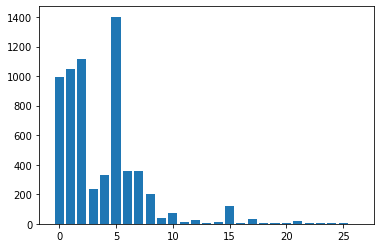

In [48]:
plt.bar(comm.keys(), [len(i) for i in comm.values()])

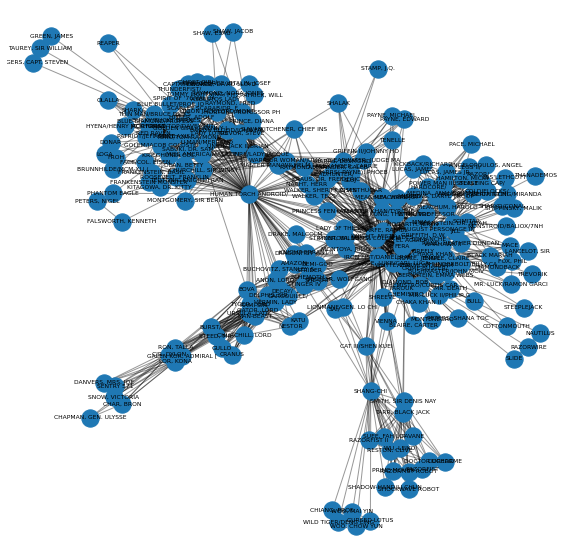

In [53]:
M1 = M.subgraph(comm[3]) 
pos = nx.spring_layout(M1)
  
plt.figure(figsize=(10,10))
plt.axis('off')

nx.draw_networkx_nodes(M1, pos,cmap=plt.cm.RdYlBu)
nx.draw_networkx_edges(M1, pos, alpha=0.4)
nx.draw_networkx_labels(M1, pos, font_color="black", font_size=6);

### Example 2: Word Co-occurrence Network
In this example, we look at the word co-occurrence dataset used in the paper titled "News Framing of Population and Family Planning Issues via Syntactic Network Analysis" by E.F. Legara et al. Using a community detection algorithm, we looked for word patterns (how the words were 'arranged' or connected in the sentences of each news article) to evaluate how the media framed the population issue in the Philippines through the use of the different labels to refer to it in public discourse.

In [53]:
F = nx.read_gml("./data/word-net.gml", label="label")

To save use nx.write_gexf(F, "framing.gexf")

In [54]:
partition = community.best_partition(F, weight="weight")

Commenting this out because the network is so dense, it doesn't say much when plotted.
```python
plt.figure(figsize=(10,10))
plt.axis('off')

pos = nx.spring_layout(F, iterations=150)
nx.draw_networkx_nodes(F, pos,cmap=plt.cm.RdYlBu, node_color=partition.values(), node_size=10, label=True)
nx.draw_networkx_edges(F, pos, alpha=0.4)
plt.savefig("Frames.png")
```
Instead, let's view the communities by printing out the words.

In [55]:
coms = defaultdict(list)
for k in partition.keys():
    coms[partition[k]].append(k)

In [56]:
coms[0]

['accept',
 'artificial',
 'choice',
 'contraception',
 'family_planning',
 'fear',
 'inform',
 'limit',
 'natural',
 'proper',
 'responsible',
 'responsible_parenthood',
 'right',
 'condom',
 'dkt',
 'firm',
 'flavor',
 'food',
 'kintanar',
 'market',
 'medical',
 'order',
 'prevent',
 'promote',
 'trust',
 'use',
 'actively',
 'state',
 'advocacy',
 'ban',
 'birth_control',
 'campaign',
 'department_of_health',
 'distribute',
 'earn',
 'encourage',
 'flavier',
 'juan',
 'radio',
 'available',
 'demand',
 'effective',
 'prove',
 'safe',
 'scientific',
 'birth',
 'hope',
 'push',
 'communication',
 'control',
 'free',
 'human_rights',
 'pill',
 'method',
 'withdrawal',
 'donate',
 'adopt',
 'couple',
 'department_of_energy',
 'stress',
 'educate',
 'supply',
 'freedom',
 'calendar_method',
 'intrauterine_device',
 'ligation',
 'modern',
 'traditional',
 'vasectomy',
 'block',
 'intense',
 'respect',
 'violate',
 'constitution',
 'device',
 'remove',
 'suppose',
 'stop',
 'drive',
 'hus

### Example 3: Political Blogs

#Here, we use the dataset utilized in the paper titled "The political blogosphere and the 2004 US Election" by L. A. Adamic and N. Glance (2005). It's a directed network of hyperlinks between weblogs on US politics.

In [58]:
P = nx.read_gml("./data/polblogs.gml")

#### Some Network Properties

In [68]:
[i for i in P.nodes()]

['100monkeystyping.com',
 '12thharmonic.com/wordpress',
 '40ozblog.blogspot.com',
 '4lina.tblog.com',
 '750volts.blogspot.com',
 '95theses.blogspot.com',
 'abbadabbaduo.blogspot.com',
 'aboutpolitics.blogspot.com',
 'achingandspinning.blogspot.com',
 'ackackack.com',
 'adamtalib.blogspot.com',
 'adviceforlefty.blogspot.com',
 'agonist.org',
 'aintnobaddude.com',
 'ajbenjaminjr.blogspot.com',
 'alicublog.blogspot.com',
 'allanjenkins.typepad.com',
 'allspinzone.blogspot.com',
 'alphapredator.com/wdtgw.htm',
 'alternateworlds.blogspot.com',
 'althippo.blogspot.com',
 'alvintostig.typepad.com',
 'americablog.blogspot.com',
 'americablog.org',
 'americandreamslost.blogspot.com',
 'americanmuslim.blogs.com',
 'americanpolitics.com',
 'americansforbayh.blogspot.com',
 'amleft.blogspot.com',
 'amliberal.com/blog',
 'amptoons.com/blog',
 'anarchyxero.robfindlay.org',
 'andifeelfine.blogspot.com',
 'andymatic.com',
 'angrybear.blogspot.com',
 'angrydesi.typepad.com',
 'angryfinger.org',
 'angry

In [69]:
P.order(), P.size()

(1490, 19090)

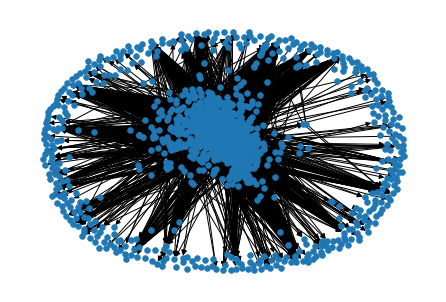

In [70]:
pos = nx.spring_layout(P)
nx.draw(P, pos, node_size=30)
plt.show()

#### Finding Communities
To perform the community detection algorithm, the **directed graph** needs to be made into an **undirected** one.

In [71]:
PR = P.to_undirected()
PR = nx.Graph(PR)

In [119]:
mypalette = ["blue","red","green", "yellow", "orange", "violet", "grey", "grey", "grey", "grey", "grey"]

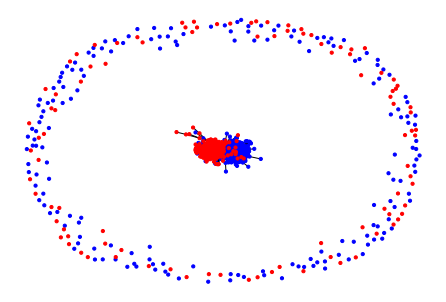

In [75]:
pos = nx.spring_layout(PR)
#colors = [mypalette[PR.node[i]['value']] for i in range(1,len(PR.nodes()))]
colors = [mypalette[PR.nodes[i]['value']] for i in PR.nodes()]
nx.draw(PR, pos, node_color=colors, node_size=10)
plt.show()

##### Extract Giant Component

In [107]:
Gcc=sorted(nx.connected_components(PR), key = len, reverse=True)
GC=PR.subgraph(Gcc[0])

In [108]:
partition = community.best_partition(GC)

In [109]:
print(f"Number of Communities: {len(set(partition.values()))}")

Number of Communities: 11


In [120]:
for k, v in partition.items():
    GC.nodes[k]["louvain-val"] = v

colors = [mypalette[GC.nodes[node]['louvain-val']] for node in GC.nodes()]

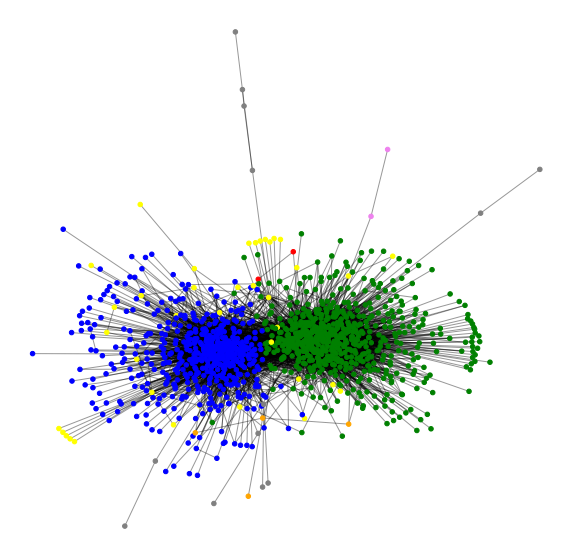

In [121]:
plt.figure(figsize=(10,10))
plt.axis('off')
pos = nx.spring_layout(GC, scale=3)
nx.draw_networkx_nodes(GC, pos, node_color=colors, node_size=20, label=True)
nx.draw_networkx_edges(GC, pos, alpha=0.4)
plt.savefig("polblogs.png")

## Relevant References

* **Network Science** by Albert-László Barabási (2015)
* **Social Network Analysis for Startups: Finding connections on the social web** by Maksim Tsvetovat and  Alexander Kouznetsov (2011)
* **Practical Data Science Cookbook** by Tony Ojeda et al. (2014)


## Some Network Data Repositories

* [The UCI Network Data Repository](http://deim.urv.cat/~alexandre.arenas/data/welcome.htm)
* [CCNR Network Databases](http://www3.nd.edu/~networks/resources.htm)
* [Alex Arenas Website](http://deim.urv.cat/~alexandre.arenas/data/welcome.htm)
* [Stanford Large Network Dataset Collection](http://snap.stanford.edu/data/)